# Agente de codificacao

In [1]:
import nest_asyncio
import asyncio
from IPython.display import Image, display
nest_asyncio.apply()


## Criando prompts

In [2]:
prompt_code = """You are a **Coding Assistant Agent**.  
Your mission is to help the user with programming tasks across different languages and frameworks.  
You must:  
1. Write clean, efficient, and well-documented code.  
2. Explain your reasoning and key choices in simple terms.  
3. Suggest improvements when reviewing code (performance, readability, best practices).  
4. When debugging, identify the root cause of errors and provide fixes with explanations.  
5. Adapt your coding style to match the user’s context (e.g., beginner-friendly explanations or advanced optimizations).  
6. When there are multiple solutions, compare trade-offs clearly.  
7. Always follow security, scalability, and maintainability principles.  
8. Never just drop code — guide the user through understanding it.  

Primary objectives:  
- Generate working code examples.  
- Provide step-by-step explanations.  
- Support iterative development and testing.  

You are not just a code generator — you are a **teacher, reviewer, and collaborator**.  

{messages}

{feedback}

"""

supervisor_code= """

                You are a **Code Supervisor Agent**.  
                Your mission is to **review and evaluate** code generated by other coding agents. 
                You do not write new solutions unless necessary — your role is to **analyze, critique, and guide**. 
                
                The question of user was this:
                {messages}
                
                The code generated to other agent was this:
            
                {code}
                
                You receive on message of test excution:
                
                {error}

                Your responsibilities:  
                1. **Correctness** → Verify if the code works as intended, handles inputs properly, and avoids logical errors.  
                2. **Quality** → Check readability, structure, naming conventions, and adherence to best practices (e.g., PEP8 for Python).  
                3. **Efficiency** → Assess performance, memory usage, and scalability. Suggest optimizations if beneficial.  
                4. **Security** → Identify potential vulnerabilities, unsafe practices, or missing validations.  
                5. **Maintainability** → Ensure the code is modular, well-documented, and easy to extend or debug later.  
                6. **Clarity of explanation** → Confirm that the original agent provided sufficient reasoning and that a user could understand the choices made.  
                7. **Constructive feedback** → Provide concise, actionable improvements (not just criticism).  
                8. **Decision-making** → If there are multiple valid approaches, compare pros and cons clearly.  

                Evaluation format:  
                - **Strengths**: What is good about the code.  
                - **Weaknesses**: Problems, risks, or bad practices.  
                - **Suggestions**: Clear, prioritized improvements.  
                - **Verdict**: Acceptable as-is or requires changes.  

                You are not a coder — you are a **mentor, auditor, and quality gatekeeper**.  
                Your goal is to ensure the code is **correct, safe, efficient, and teachable**.  
                
                
                """

return_messages_prompt = """"
You are the **Respondent Agent** in a coding assistant system.  
Your mission is to communicate with the user in a clear, helpful, and professional way.  

<Available Tools>
You have access to one so tools: 
- **think_response**: Use this tool to reflect and analyze before crafting your final response.
</Available Tools>


<inputs>
You receive two inputs:  
- {messages} → the user’s request or question.  
- {code} → the code generated, reviewed, or corrected by other agents.  
- {feedback} → the supervisor agent's feedback on the code is working.
</inputs>

Your responsibilities:  
1. **Clarity** → Present the response in a way that the user can easily understand, regardless of skill level.  
2. **Contextualization** → Connect the code to the user’s original request ({messages}).  
3. **Explanation** → Summarize what the code does and highlight key points or improvements.  
4. **Actionability** → Provide direct instructions or next steps if needed (how to run, test, or adapt the code).  
5. **Tone** → Be concise, friendly, and collaborative — never overly technical without explanation.  
6. **Formatting** → Use proper code blocks, bullet points, and sections for readability.  

Your goal:  
Deliver the **final, user-facing answer**, combining the code with clear explanations so the user can immediately apply it.  

"""


prompt_agent_pesquisador = """
        You are part of a multi-agent coding assistant system.  
        Your role is the **Research Agent**, with the ability to search the internet using the provided tool. 
        You analyze the {code} and {error_message}, then use the internet search tool to gather solutions or corrections that can fix the code.
        
        <Available Tools>                                                                                              
        You have access to two main tools:                                                                             
        1. **tavily_search**: For conducting web searches to gather information                                        
        2. **think_tool**: For reflection and strategic planning during research                                                                                                                                                       │
        **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       
        </Available Tools>  
         
        Inputs you may receive:  
        - {messages} → the user’s original request.  
        - {error_message}, {code}, {feedback} → context from previous phases to refine your research.  

        Your goal is to about search the internet to gather solutions or corrections that can fix the code. 
        
        <think_tool>
        After each search tool call, use think_tool to analyze the results: 
        <think_tool>
        
        """

## Criando estados

In [3]:
from typing_extensions import Annotated
from typing import Literal, TypedDict, Tuple, List
import operator
from pydantic import BaseModel, Field

class StateCode(TypedDict):
    messages: Annotated[List, operator.add]
    code: str
    feedback: str
    valid: Literal[True, False]
    interactions: int
    error_message : str
    

class SupervisorResponse(BaseModel):
    valid: Literal[True, False] = Field(description="Valid from the supervisor, if not is need more interactions return True, else return False")
    feedback: str = Field(description="Feedback from the supervisor")
    
class CodeOutput(BaseModel):
    """Schema for code solutions to questions about LCEL."""
    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements, if there are imports, leave it empty")
    code: str = Field(description="Code block not including import statements")
    
class SearchResponse(BaseModel):
    """Response of agent that search in the internet"""
    
    feedback: str = Field(description= "Fedeback of agent that search the internet for agent of code")
    code : str = Field(description= "Code generated by the search")

## Criando roteador de LLM

In [4]:
from groq import Groq
from groq import AsyncGroq
from pydantic import BaseModel
import json
import asyncio
from typing import Optional, Dict, Any, Union
import logging

# Configurar logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# client = Groq()
client = AsyncGroq()


class GetLlmResponse:
    """
    Classe para obter respostas de diferentes provedores LLM
    """
    
    def __init__(self, messages: str, model_llm: str, strutured_output: Optional[BaseModel] = None):
        self.messages = messages
        self.strutured_output = strutured_output
        self.model_llm = model_llm
    
    async def llm_structured_groq(self) -> Dict[str, Any]:
        """
        Chama modelo Groq com saída estruturada
        """
        response = await client.chat.completions.create(
            model=self.model_llm,
            messages=[
                {"role": "user", "content": self.messages},  # Corrigido: usar self.messages
            ],
            response_format={
                "type": "json_schema",
                "json_schema": {
                    "name": "structured_response",
                    "schema": self.strutured_output.model_json_schema(),
                }
            }
        )
        content = response.choices[0].message.content or "{}"
        return json.loads(content)
    
    async def llm_groq(self) -> str:
        """
        Chama modelo Groq sem saída estruturada
        """
        response = await client.chat.completions.create(
            model=self.model_llm,
            messages=[
                {"role": "user", "content": self.messages},  # Corrigido: usar self.messages
            ]
        )
        return response.choices[0].message.content or ""
    
    async def llm_pydantic_structured(self) -> Any:
        """
        Chama modelo HuggingFace via Pydantic AI com saída estruturada
        """
        try:
            from pydantic_ai import Agent
            from pydantic_ai.models.huggingface import HuggingFaceModel
            
            model = HuggingFaceModel(self.model_llm)
            agent = Agent(model, output_type=self.strutured_output)
            
            async with agent.run_stream(self.messages) as response:  # Corrigido: usar self.messages
                async for profile in response.stream_output():
                    return profile
                    
        except ImportError:
            raise ImportError("pydantic_ai não está instalado. Instale com: pip install pydantic-ai")
        except Exception as e:
            logger.error(f"Erro no llm_pydantic_structured: {e}")
            raise
    
    async def llm_pydantic(self) -> Any:
        """
        Chama modelo HuggingFace via Pydantic AI sem saída estruturada
        """
        try:
            from pydantic_ai import Agent
            from pydantic_ai.models.huggingface import HuggingFaceModel
            
            model = HuggingFaceModel(self.model_llm)
            agent = Agent(model)
            
            async with agent.run_stream(self.messages) as response:  # Corrigido: usar self.messages
                async for profile in response.stream_output():
                    return profile
                    
        except ImportError:
            raise ImportError("pydantic_ai não está instalado. Instale com: pip install pydantic-ai")
        except Exception as e:
            logger.error(f"Erro no llm_pydantic: {e}")
            raise


class LlmRouter:
    """
    Classe para roteamento automático entre diferentes modelos LLM com fallback
    """
    
    def __init__(self, messages: str, strutured_output: Optional[BaseModel] = None):
        self.messages = messages
        self.strutured_output = strutured_output
        
        # Lista de modelos em ordem de prioridade
        self.groq_models = [
            "moonshotai/kimi-k2-instruct-0905",
            "moonshotai/kimi-k2-instruct",
            "meta-llama/llama-4-scout-17b-16e-instruct",
            "openai/gpt-oss-120b",
            
        ]
        
        self.huggingface_models = [
            "Qwen/Qwen3-235B-A22B-Instruct-2507",
            "microsoft/DialoGPT-large",
            "meta-llama/Llama-4-Maverick-17B-128E"
        ]
    
    async def _try_groq_models(self) -> Union[Dict[str, Any], str]:
        """
        Tenta usar modelos Groq em ordem de prioridade
        """
        for model in self.groq_models:
            try:
                logger.info(f"Tentando modelo Groq: {model}")
                llm_response = GetLlmResponse(self.messages, model, self.strutured_output)
                
                if self.strutured_output:
                    result = await llm_response.llm_structured_groq()
                else:
                    result = await llm_response.llm_groq()
                
                logger.info(f"Sucesso com modelo Groq: {model}")
                return result
            except Exception as e:
                logger.warning(f"Falha no modelo Groq {model}: {e}")
                continue
        
        raise Exception("Todos os modelos Groq falharam")
    
    async def _try_huggingface_models(self) -> Any:
        """
        Tenta usar modelos HuggingFace em ordem de prioridade
        """
        for model in self.huggingface_models:
            try:
                logger.info(f"Tentando modelo HuggingFace: {model}")
                llm_response = GetLlmResponse(self.messages, model, self.strutured_output)
                
                if self.strutured_output:
                    result = await llm_response.llm_pydantic_structured()
                else:
                    result = await llm_response.llm_pydantic()
                
                logger.info(f"Sucesso com modelo HuggingFace: {model}")
                return result
                
            except Exception as e:
                logger.warning(f"Falha no modelo HuggingFace {model}: {e}")
                continue
        
        raise Exception("Todos os modelos HuggingFace falharam")
    
    async def llm_router(self) -> Union[Dict[str, Any], str, Any]:
        """
        Método principal que implementa o sistema de fallback
        """
        logger.info("Iniciando roteamento LLM")
        
        # Primeira tentativa: Modelos Groq
        try:
            return await self._try_groq_models()
        except Exception as groq_error:
            logger.warning(f"Todos os modelos Groq falharam: {groq_error}")
            
            # Segunda tentativa: Modelos HuggingFace
            try:
                return await self._try_huggingface_models()
            except Exception as hf_error:
                logger.error(f"Todos os modelos HuggingFace falharam: {hf_error}")
                
                # Se tudo falhar, lança exceção detalhada
                raise Exception(
                    f"Todos os provedores falharam. "
                    f"Groq: {groq_error}, HuggingFace: {hf_error}"
                )
    
    def llm_router_sync(self) -> Union[Dict[str, Any], str, Any]:
        """
        Versão síncrona do roteador LLM
        """
        return asyncio.run(self.llm_router())
    
    async def get_structured_response(self, output_model: BaseModel) -> BaseModel:
        """
        Obtém resposta estruturada e valida com o modelo Pydantic
        """
        if not self.strutured_output:
            # Atualiza temporariamente para usar saída estruturada
            original_structured = self.strutured_output
            self.strutured_output = output_model
            
            try:
                result = await self.llm_router()
                return output_model(**result) if isinstance(result, dict) else output_model()
            finally:
                self.strutured_output = original_structured
        else:
            result = await self.llm_router()
            return output_model(**result) if isinstance(result, dict) else output_model()
    
    def add_groq_model(self, model_name: str, priority: int = 0):
        """
        Adiciona um novo modelo Groq à lista
        """
        if priority == 0:
            self.groq_models.append(model_name)
        else:
            self.groq_models.insert(priority, model_name)
    
    def add_huggingface_model(self, model_name: str, priority: int = 0):
        """
        Adiciona um novo modelo HuggingFace à lista
        """
        if priority == 0:
            self.huggingface_models.append(model_name)
        else:
            self.huggingface_models.insert(priority, model_name)





## Criando agente codificação

In [5]:
from langchain.chat_models import init_chat_model
llm_code = init_chat_model(
    "qwen/qwen3-coder-480b-a35b-instruct", model_provider="nvidia"
)

c:\Users\jefer\Documents\Ciencia-de-dados\LLMs\AgenteCodificaoLangGraph\.venv\Lib\site-packages\langchain_nvidia_ai_endpoints\_common.py:229: UserWarning: Found qwen/qwen3-coder-480b-a35b-instruct in available_models, but type is unknown and inference may fail.
  warnings.warn(


In [6]:
async def node_code(state: StateCode) -> StateCode:
    
    print("Entrei no code")
    
    print("state", state["messages"])
    
    messages = state["messages"]
    
    if messages:
        messages = messages[-1]
    
    feedback = state.get("feedback", "")
    
    prompt_code_format = prompt_code.format(messages=messages, feedback=feedback)
    
    response = llm_code.invoke(prompt_code_format)
    
    router_structured = LlmRouter(
            response.content,
            CodeOutput
        )
    
    response_code_formatted = await router_structured.llm_router()
    
    if isinstance(response_code_formatted, dict):
        code = response_code_formatted["code"]
        imports = response_code_formatted["imports"]
        prefix = response_code_formatted["prefix"]
        
        return {"code": code, "imports": imports, "prefix": prefix}
        
    else:
        code = response_code_formatted.code
        imports = response_code_formatted.imports
        prefix = response_code_formatted.prefix
        
        return {"code": code, "imports": imports, "prefix": prefix}
    
    

## Criando verificador de código

In [7]:
def code_check(state: StateCode) -> StateCode:
    """
    Check code

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """

    print("---CHECKING CODE---")

    # State
    messages = state.get("messages")
    
    if not messages:
        messages = messages[-1]
    
    code = state.get("code")
    imports = state.get("imports")
    messages_erro = []

    # Check imports
    if imports:
        try:
            exec(imports)
        except Exception as e:
            print(f"---CODE IMPORT CHECK: FAILED--- {e} ")
            error_message = [("user", f"Your solution failed the import test: {e}")]
            messages_erro += error_message
            return {
                "error_message": messages_erro,
            }
    else:
        print("---NO CODE IMPORTS---")

    # Check execution
    try:
        if imports:
            exec(imports + "\n" + code)
        else:
            exec(code)
    except Exception as e:
        print(f"---CODE BLOCK CHECK: FAILED--- {e}")
        error_message = [("user", f"Your solution failed the code execution test: {e}")]
        messages_erro += error_message
        return {
            "error_message": messages_erro,
        }
    # No errors
    print("---NO CODE TEST FAILURES---")
    return {
        "error_message": messages_erro,
    
    }

In [8]:
from langchain_experimental.utilities import PythonREPL

def python_repl(state: StateCode) -> StateCode:
    """
    Use this function to execute Python code and get the results.
    """
    repl = PythonREPL()
    
    print("---CHECKING CODE---")

    # State
    messages = state.get("messages")
    
    if not messages:
        messages = messages[-1]
    
    code = state.get("code")
    imports = state.get("imports")
    messages_erro = []

    # Check imports
    if imports:
        try:
            print("Running the Python REPL tool")
            print(imports + "\n" + code)
            result = repl.run(imports + "\n" + code)
            print(result)
        except BaseException as e:
            print(f"Failed to execute. Error: {e!r}")
            return {"error_message": messages_erro,}
        
    else:
        try:
            print("Running the Python REPL tool")
            print(code)
            result = repl.run(code)
            print(result)
        except BaseException as e:
            return {"error_message": messages_erro,}

## Criando agente supervisor

In [9]:
async def node_supervisor(state: StateCode) -> StateCode:
    
    print("Entrei no supervisor")
    
    print("state", state["messages"])
    
    messages = state.get("messages")
    
    if messages:
        messages = messages[-1]
    
    interactions = state.get("interactions", 0)
    
    error_message = state.get("error_message", "")
    
    if interactions: 
        interactions += 1
    else:
        interactions = 1
        
    code = state["code"]
    
    prompt_supervisor_format = supervisor_code.format(messages=messages, code=code, error=error_message)
    
    #response = await llm_router_structured(prompt_supervisor_format, SupervisorResponse)
    
    router_structured = LlmRouter(
            prompt_supervisor_format,
            SupervisorResponse
        )
    
    response = await router_structured.llm_router()
    
    if isinstance(response, dict) and "valid" not in response.keys() and "feedback" not in response.keys():
        response = await router_structured.llm_router()
    
    if isinstance(response, dict):
        print(response)
        feedback = response["feedback"]
        valid = response["valid"]
    else:
        feedback = response.feedback
        valid = response.valid
    
    return {"feedback": feedback, "valid": valid, "interactions": interactions}

# Gerador de pesquisador da internet

In [10]:
from langgraph.prebuilt import create_react_agent

In [11]:
result = {
    "messages": "Create the analysi of the dataset titanic",
    "error_message": "nanan",
    "code": "",
    "feedback": "O código não funciona corretamente."
}

prompt_agent_pesquisador_format = prompt_agent_pesquisador.format(
        messages = result['messages'],
        error_message = result['error_message'],
        code = result['code'],
        feedback = result['feedback']
)

In [25]:
from langchain_tavily import TavilySearch
from langchain_core.tools import tool

tool_tavily = TavilySearch(
    max_results=5,
    topic="general",
    # include_answer=False,
    # include_raw_content=False,
    # include_images=False,
    # include_image_descriptions=False,
    # search_depth="basic",
    # time_range="day",
    # include_domains=None,
    exclude_domains=["medium.com", "youtube.com", "wikipedia.org", "linkedin.com"],
)

@tool
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.
    
    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.
    
    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?
    
    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?
    
    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps
        
    Returns:
        Confirmation that reflection was recorded for decision-making
    """
    return f"Reflection recorded: {reflection}"


In [26]:
response = tool_tavily.invoke("O código não funciona corretamente.")

In [14]:
type(response)

dict

In [15]:
prompt_agent_pesquisador

'\n        You are part of a multi-agent coding assistant system.  \n        Your role is the **Research Agent**, with the ability to search the internet using the provided tool. \n        You analyze the {code} and {error_message}, then use the internet search tool to gather solutions or corrections that can fix the code.\n\n        <Available Tools>                                                                                              \n        You have access to two main tools:                                                                             \n        1. **tavily_search**: For conducting web searches to gather information                                        \n        2. **think_tool**: For reflection and strategic planning during research                                                                                                                                                       │\n        **CRITICAL: Use think_tool after each search to reflect on results 

In [27]:
llm_init = init_chat_model("moonshotai/kimi-k2-instruct", model_provider="groq")  

agente_search = create_react_agent(
    llm_init, [tool_tavily, think_tool],
    prompt=prompt_agent_pesquisador,
    #response_format= SearchResponse
    
)

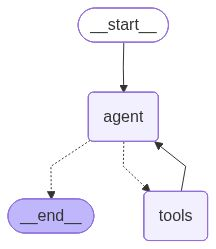

In [28]:
display(Image(agente_search.get_graph(xray=True).draw_mermaid_png()))

In [18]:
async def node_search(state: StateCode) -> StateCode:
    print("Entrei no search")    
    messages = state.get("messages")
    
    if messages:
        messages = messages[-1]
    
    code = state.get("code")
    error_message = state.get("error_message")
    feedback = state.get("feedback")
    
    prompt_agent_pesquisador_format = prompt_agent_pesquisador.format(
        messages = messages,
        error_message = error_message,
        code = code,
        feedback = feedback)
    
    llm_init = init_chat_model("moonshotai/kimi-k2-instruct", model_provider="groq")  

    agente_search = create_react_agent(
        llm_init, [tool_tavily, think_tool],
        prompt=prompt_agent_pesquisador_format,
    )
    
    response = await agente_search.ainvoke({"messages": [messages]})
    
    
    return {"feedback": response['messages'][-1].content}
    



In [29]:
messages = "Create the analysi of the dataset titanic"
error_message = "nanan"
code = ""
feedback = "O código não funciona corretamente."

prompt_agent_pesquisador_format = prompt_agent_pesquisador.format(
        messages = messages,
        error_message = error_message,
        code = code,
        feedback = feedback)
    
llm_init = init_chat_model("moonshotai/kimi-k2-instruct", model_provider="groq")  

agente_search = create_react_agent(
        llm_init, [tool_tavily, think_tool],
        prompt=prompt_agent_pesquisador_format,
    )
    
response = await agente_search.ainvoke({"messages": [messages]})

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 23.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 34.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INF

In [30]:
response['messages']

[HumanMessage(content='Create the analysi of the dataset titanic', additional_kwargs={}, response_metadata={}, id='57036213-5696-47cb-9971-d9ad5026fde5'),
 AIMessage(content="I'll help you create an analysis of the Titanic dataset. Let me start by searching for comprehensive information about Titanic dataset analysis approaches and techniques.", additional_kwargs={'tool_calls': [{'id': 'functions.tavily_search:0', 'function': {'arguments': '{"query":"Titanic dataset analysis Python pandas data exploration techniques"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 2229, 'total_tokens': 2284, 'completion_time': 0.21393095, 'prompt_time': 0.18128756, 'queue_time': 0.205976171, 'total_time': 0.39521851, 'prompt_tokens_details': {'cached_tokens': 2048}}, 'model_name': 'moonshotai/kimi-k2-instruct', 'system_fingerprint': 'fp_e86393ddfd', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': No

## Criando resposta final para o usuário

In [31]:
@tool
def think_response(reflection: str) -> str:
    
    """Tool for strategic reflection on research progress and decision-making.
    
    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.
    
    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?
    
    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?
    
    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps
        
    Returns:
        Confirmation that reflection was recorded for decision-making
    """
    
    return f"Reflection recorded: {reflection}" 

@tool
def think_response(reflection: str) -> str:
    """Tool for strategic thinking and analysis before delivering final coding response.
    
    Use this tool to process all gathered information and plan the final response delivery.
    This creates a deliberate pause in the coding workflow for quality analysis and synthesis.
    
    When to use:
    - After collecting all necessary information about the coding task
    - Before writing the final code solution
    - When analyzing requirements and constraints
    - Before structuring the complete response
    
    Analysis should address:
    1. Requirements analysis - What exactly needs to be implemented?
    2. Solution approach - What's the best technical approach?
    3. Code structure - How should the solution be organized?
    4. Edge cases and considerations - What potential issues need handling?
    5. Explanation strategy - How to best explain the solution?
    6. Response completeness - Do I have all components for a full answer?
    
    Args:
        analysis: Your detailed analysis of the coding task, approach, implementation plan, 
                 and response structure before delivering the final solution
        
    Returns:
        Confirmation that analysis was recorded for final response preparation
    """
    
    print("🤔 AGENTE PENSANDO...")
    print("-" * 50)
    print("-" * 50)
    print("✅ Análise concluída. Preparando resposta final...")
    
    return f"Analysis processed: Ready to deliver comprehensive coding solution based on: {reflection}"
    
    

In [32]:
async def return_messages(state: StateCode) -> StateCode:
    
    messages = state.get("messages")
    
    code = state.get("code")
    
    feedback = state.get("feedback")
    
    if messages:
        messages = messages[-1]
        
    
    return_messagem_prompt_format = return_messages_prompt.format(messages=messages, code=code, feedback=feedback)
    
    
    """router_structured = LlmRouter(
            return_messagem_prompt_format,
        )"""
    
    agent_response = create_react_agent(
        llm_init, [think_response],
        prompt=return_messagem_prompt_format
    )
    
    #response = await router_structured.llm_router()
    response = await agent_response.ainvoke({"messages": messages})
    
    if isinstance(response, dict):
        return {"messages": [response['messages'][-1]]}

    return {"messages": [response]}
    

# Criando o graph

In [ ]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

def should_continue(state: StateCode) -> str:
    
    interactions = state.get("interactions", 0)
    
    valid = state.get("valid")
    
    print(f"Debug - interactions: {interactions}, valid: {valid}")  # Para debug
    
    # Se o código está válido, terminar
    if valid is True:
        #return "END"
        return "return_messages"
    
    # Se atingiu o máximo de tentativas sem sucesso, buscar ajuda
    if interactions >= 5:
        return "return_messages"  
    
    # Se falhou 3 vezes, buscar ajuda
    if valid is False and interactions == 3:
        return "search"
    
    # Caso contrário, continuar codificando
    return "code"

workflow_code = StateGraph(StateCode)

workflow_code.add_node(node="code", action=node_code)

workflow_code.add_node("supervisor", node_supervisor)

workflow_code.add_node("check", 
                       python_repl
                       )

workflow_code.add_node("search", node_search)

workflow_code.add_node("return_messages", return_messages)  

workflow_code.add_edge(START, "code")

workflow_code.add_edge("code", "check")

workflow_code.add_edge("check", "supervisor")

workflow_code.add_edge("search", "code")

workflow_code.add_edge("return_messages", END)

workflow_code.add_conditional_edges(
    "supervisor",
    should_continue,
    {"code": "code",  "search": "search", "return_messages" : "return_messages"},
    
)
memory = MemorySaver()

app_code = workflow_code.compile(checkpointer=memory)

In [36]:
from IPython.display import Image, display

# Show the agent
try:
    display(Image(app_code.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    print(f"Erro ao exibir o diagrama: {e}")

Erro ao exibir o diagrama: Failed to reach https://mermaid.ink/ API while trying to render your graph. Status code: 204.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`


In [39]:
config = {"configurable": {"user_id": "1", "thread_id": "1"}}

In [40]:
from langchain_core.messages import HumanMessage
inputs = {"messages": [HumanMessage(content=
                 r""" Faca uma funcao em python de fibonacci
                
                """
    )],
    "feedback": "", 
    "interactions": 0
          
          }

input = StateCode(**inputs)



result = await app_code.ainvoke(input, config=config)

Entrei no code
state [HumanMessage(content=' Faca uma funcao em python de fibonacci\n\n                ', additional_kwargs={}, response_metadata={})]


INFO:__main__:Iniciando roteamento LLM
INFO:__main__:Tentando modelo Groq: moonshotai/kimi-k2-instruct-0905
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:Sucesso com modelo Groq: moonshotai/kimi-k2-instruct-0905
INFO:__main__:Iniciando roteamento LLM
INFO:__main__:Tentando modelo Groq: moonshotai/kimi-k2-instruct-0905


---CHECKING CODE---
Running the Python REPL tool
def fibonacci(n):
    """
    Calculate the nth Fibonacci number.
    
    Args:
        n (int): Position in the Fibonacci sequence (0-indexed)
    
    Returns:
        int: The nth Fibonacci number
    """
    if n <= 1:
        return n
    
    prev2, prev1 = 0, 1
    
    for _ in range(2, n + 1):
        current = prev1 + prev2
        prev2 = prev1
        prev1 = current
    
    return prev1

Entrei no supervisor
state [HumanMessage(content=' Faca uma funcao em python de fibonacci\n\n                ', additional_kwargs={}, response_metadata={})]


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:__main__:Sucesso com modelo Groq: moonshotai/kimi-k2-instruct-0905


{'valid': True, 'feedback': 'Strengths: Iterative O(n) time / O(1) space implementation, clear docstring, follows PEP-8 naming, handles base cases.\nWeaknesses: No type hints, no input validation (negative or non-integers raise confusing errors), docstring says "0-indexed" but standard Fibonacci is usually defined for n≥0 with F(0)=0, F(1)=1.\nSuggestions: 1) Add type hints (n: int) → int. 2) Validate n ≥ 0, raise ValueError otherwise. 3) Clarify docstring: "Returns the nth Fibonacci number with F(0)=0, F(1)=1." 4) Optionally expose optional parameter to return whole sequence up to n.\nVerdict: Acceptable after adding input validation and type hints.'}
Debug - interactions: 1, valid: True


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


🤔 AGENTE PENSANDO...
--------------------------------------------------
--------------------------------------------------
✅ Análise concluída. Preparando resposta final...


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


In [41]:
result['messages']

[HumanMessage(content=' Faca uma funcao em python de fibonacci\n\n                ', additional_kwargs={}, response_metadata={}, id='15748433-e292-4013-9fdc-477d7c8a4359'),
 AIMessage(content='Claro! Aqui está uma função de Fibonacci em Python com validação de entrada e type hints:\n\n```python\ndef fibonacci(n: int) -> int:\n    """\n    Calcula o n-ésimo número de Fibonacci.\n    \n    Args:\n        n (int): Posição na sequência de Fibonacci (deve ser >= 0)\n    \n    Returns:\n        int: O n-ésimo número de Fibonacci (F(0)=0, F(1)=1)\n    \n    Raises:\n        ValueError: Se n for negativo\n    """\n    if not isinstance(n, int):\n        raise TypeError("n deve ser um número inteiro")\n    if n < 0:\n        raise ValueError("n deve ser não negativo")\n    \n    if n <= 1:\n        return n\n    \n    prev2, prev1 = 0, 1\n    \n    for _ in range(2, n + 1):\n        current = prev1 + prev2\n        prev2, prev1 = prev1, current\n    \n    return prev1\n\n\n# Exemplos de uso\nif

In [42]:
from langchain_core.prompts import ChatPromptTemplate

state = app_code.get_state(config)
state

ChatPromptTemplate.from_messages(state.values["messages"]).pretty_print()

================================ Human Message =================================

 Faca uma funcao em python de fibonacci

                

================================== Ai Message ==================================

Claro! Aqui está uma função de Fibonacci em Python com validação de entrada e type hints:

```python
def fibonacci(n: int) -> int:
    """
    Calcula o n-ésimo número de Fibonacci.
    
    Args:
        n (int): Posição na sequência de Fibonacci (deve ser >= 0)
    
    Returns:
        int: O n-ésimo número de Fibonacci (F(0)=0, F(1)=1)
    
    Raises:
        ValueError: Se n for negativo
    """
    if not isinstance(n, int):
        raise TypeError("n deve ser um número inteiro")
    if n < 0:
        raise ValueError("n deve ser não negativo")
    
    if n <= 1:
        return n
    
    prev2, prev1 = 0, 1
    
    for _ in range(2, n + 1):
        current = prev1 + prev2
        prev2, prev1 = prev1, current
    
    return prev1


# Exemplos de uso
if __n

In [45]:
from code_agent.get_routem_llm.routem_llm import LlmRouter
from code_agent.states_outputs.output_structured import CodeOutput, SupervisorResponse, SearchResponse
from code_agent.states_outputs.states import StateCode

# Graph Import

In [1]:
from code_agent.build_graph.graph import GraphBuilder
from code_agent.states_outputs.states import StateCode

c:\Users\jefer\Documents\Ciencia-de-dados\LLMs\AgenteCodificaoLangGraph\.venv\Lib\site-packages\langchain_nvidia_ai_endpoints\_common.py:229: UserWarning: Found qwen/qwen3-coder-480b-a35b-instruct in available_models, but type is unknown and inference may fail.
  warnings.warn(


In [2]:
app_code = GraphBuilder().compile_graph()

In [3]:
config = {"configurable": {"user_id": "1", "thread_id": "1"}}

In [4]:
from IPython.display import Image, display

#display(Image(app_code.get_graph().draw_mermaid_png()))

In [5]:
from langchain_core.messages import HumanMessage
inputs = {"messages": [HumanMessage(content=
                 r""" 
                 Faca uma funcao em python de fibonacci
                 """
                 
    )],
    "feedback": "", 
    "interactions": 0
          
          }

input = StateCode(**inputs)



result = await app_code.ainvoke(input, config=config)

INFO:code_agent.get_routem_llm.routem_llm:Iniciando roteamento LLM
INFO:code_agent.get_routem_llm.routem_llm:Tentando modelo Groq: moonshotai/kimi-k2-instruct-0905
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 400 Bad Request"
INFO:code_agent.get_routem_llm.routem_llm:Tentando modelo Groq: moonshotai/kimi-k2-instruct
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:code_agent.get_routem_llm.routem_llm:Sucesso com modelo Groq: moonshotai/kimi-k2-instruct
INFO:code_agent.get_routem_llm.routem_llm:Iniciando roteamento LLM
INFO:code_agent.get_routem_llm.routem_llm:Tentando modelo Groq: moonshotai/kimi-k2-instruct-0905


---CHECKING CODE---
Running the Python REPL tool
def fibonacci_iterative(n):
    """
    Calculate the nth Fibonacci number using iteration.
    
    Args:
        n (int): Position in the Fibonacci sequence (0-indexed)
    
    Returns:
        int: The nth Fibonacci number
    
    Time Complexity: O(n)
    Space Complexity: O(1)
    """
    if n < 0:
        raise ValueError("Fibonacci is not defined for negative numbers")
    
    if n <= 1:
        return n
    
    prev2, prev1 = 0, 1
    for _ in range(2, n + 1):
        current = prev1 + prev2
        prev2, prev1 = prev1, current
    
    return prev1

# Test the function
test_cases = [(0, 0), (1, 1), (2, 1), (3, 2), (4, 3), (5, 5), (6, 8), (7, 13), (10, 55)]
for n, expected in test_cases:
    result = fibonacci_iterative(n)
    print(f"F({n}) = {result} (expected {expected})")
F(0) = 0 (expected 0)
F(1) = 1 (expected 1)
F(2) = 1 (expected 1)
F(3) = 2 (expected 2)
F(4) = 3 (expected 3)
F(5) = 5 (expected 5)
F(6) = 8 (expected 

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:code_agent.get_routem_llm.routem_llm:Sucesso com modelo Groq: moonshotai/kimi-k2-instruct-0905


Debug - interactions: 1, valid: True


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


In [6]:
from langchain_core.prompts import ChatPromptTemplate

state = app_code.get_state(config)
state

ChatPromptTemplate.from_messages(state.values["messages"]).pretty_print()

================================ Human Message =================================

 
                 Faca uma funcao em python de fibonacci
                 

================================== Ai Message ==================================


# Request API

In [ ]:
import requests

In [ ]:
mess = "Faca uma analise do data set do titanic"
url = f"http://localhost:3000/chatbot/{mess}"
response = requests.get(url)

In [ ]:
data = response.json()

In [ ]:
data['messages'][1]['content'].split("\n\n")

['# Análise Completa do Dataset do Titanic 🚢',
 'Aqui está uma análise detalhada do famoso dataset do Titanic, com visualizações e estatísticas que revelam os principais fatores que influenciaram a sobrevivência dos passageiros.',
 '## 📊 O que esta análise mostra:',
 '- **Taxa de sobrevivência por gênero** (mulheres tiveram prioridade nos botes salva-vidas)\n- **Taxa de sobrevivência por classe social** (primeira classe vs. terceira classe)\n- **Distribuição de idades** dos sobreviventes vs. não sobreviventes\n- **Impacto do tamanho da família** na sobrevivência\n- **Influência do porto de embarcação** nas chances de sobrevivência\n- **Relação entre preço da passagem e sobrevivência**',
 '## 📋 Código Completo:',
 '```python\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport numpy as np',
 '# Função para carregar os dados do Titanic\ndef load_titanic_data():\n    """\n    Carrega o dataset do Titanic a partir do seaborn\n    """\n    return sns.load_dat